In [1]:
import tensorflow as tf
import test_model as tm
import numpy as np
import math 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print(tf.VERSION)

1.13.1


preparing mask

In [3]:
def getMask(size=[128,128], porder = 5.0, bias = 0.1, acs = 3, seed = 0, axis_undersample=1, mute=0):
    # init
    mask = np.zeros(size)
    np.random.seed(seed)
    # gen random mask
    for i in range(size[1]):
        x = (i-size[1]/2.0)/(size[1]/2.0)
        p = np.random.rand() 
        if p <= abs(x)**porder + bias:
            if axis_undersample == 0:
                mask[i][:]=1
            else:
                mask[:][i]=1
    # acs                
    if axis_undersample == 0:
        mask[:int((acs+1)/2)][:]=1
        mask[-int(acs/2):][:]=1
    else:
        mask[:][:int((acs+1)/2)]=1
        mask[:][-int(acs/2):]=1

    # compute reduction
    r_factor = len(mask.flatten())/sum(mask.flatten())
    if not mute:
        print('gen mask for R-factor={0:.4f}'.format(r_factor))

    # use tf
    return mask, r_factor

mask, r_factor = getMask(size=[28,28], porder=5, acs = 3)
print(r_factor, np.where(mask[0,:]))

gen mask for R-factor=3.5000
3.5 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),)


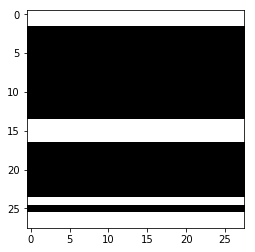

In [4]:
plt.imshow(mask, cmap = "gray")

get training data--mnist dataset

In [5]:
((train_data, train_labels),
 (eval_data, eval_labels)) = tf.keras.datasets.mnist.load_data()
train_data = train_data/np.float32(255)
eval_data = eval_data/np.float32(255)
mask = np.reshape(mask, [1, 28, 28])

In [6]:
def get_batch(size = 100):
    batch_loc = np.random.randint(60000, size=size)
    train_bat_im = train_data[batch_loc]
    return np.reshape(train_bat_im,[size, 28, 28, 1])

def get_masked(data, mask):
    d_complex = tf.reshape(tf.cast(data, tf.complex64),
                           [data.shape[0], 28, 28])
    mask_complex = tf.cast(mask, tf.complex64)
    d_kspace = tf.fft2d(d_complex)*mask_complex
    d_masked_complex = tf.ifft2d(d_kspace)
    d_masked_real = tf.reshape(tf.real(d_masked_complex), 
                               [d_masked_complex.get_shape()[0], 28, 28, 1])
    d_masked_imag = tf.reshape(tf.imag(d_masked_complex), 
                               [d_masked_complex.get_shape()[0], 28, 28, 1])
    d_masked = tf.concat([d_masked_real, d_masked_imag], axis = 3)
    with tf.Session() as sess:
        masked = sess.run(d_masked)
    return masked

In [7]:
batch = get_batch()
masked = get_masked(batch, mask)

In [8]:
m1 = tf.cast(masked[1][:][:][:], tf.complex64)
re = m1[:,:,0]+1j*m1[:,:,1]
r = tf.abs(re)
r = tf.reshape(r, [28, 28])

In [9]:
with tf.Session() as sess:
    o1 = sess.run(r)

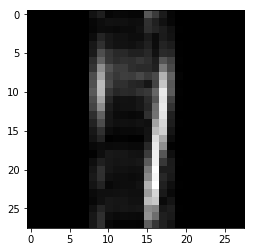

In [10]:
plt.imshow(o1, cmap = "gray")

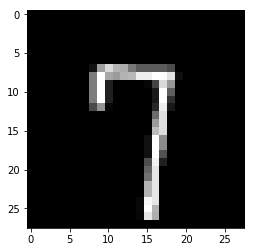

In [11]:
r1 = np.reshape(batch[1,:,:,:], [28, 28])
plt.imshow(r1, cmap = "gray")

preparing model structure

In [12]:
batchsize = 100 # change it along with test_model.py
model_input_masked = tf.placeholder(tf.float32, [batchsize, 28, 28, 2], 
                                    "masked")
model_input_gtrue = tf.placeholder(tf.float32, [batchsize, 28, 28, 1], 
                                   "ground_truth")


In [13]:
sess = tf.Session()


gene_output, gene_output_complex, gene_var_list, gene_layers, disc_real_output, disc_fake_output, disc_var_list, disc_layers = tm.create_model(sess, model_input_masked, model_input_gtrue, mask)
    
    
gene_loss, gene_dc_loss, gene_fool_loss, list_gene_lose, gene_mse_factor = tm.create_generator_loss(disc_fake_output, gene_output, gene_output_complex, model_input_masked, model_input_gtrue, mask)
    
    
disc_loss = tm.create_discriminator_loss(disc_real_output, disc_fake_output)
    
global_step, learning_rate, gene_minimize, disc_minimize = tm.create_optimizers(gene_loss, gene_var_list,disc_loss, disc_var_list)
    
    

use resnet without pooling: [64, 64, 64]
Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

using Fourier, input dim (100, 28, 28, 2), output dim (100, 28, 28)
using Fourier, input dim (100, 28, 28, 2), output dim (100, 28, 28)
use resnet without pooling: [64, 64, 64]
using Fourier, input dim (100, 28, 28, 2), output dim (100, 28, 28)
using Fourier, input dim (100, 28, 28, 2), output dim (100, 28, 28)
use resnet without pooling: [64, 64, 64]
using Fourier, input dim (100, 28, 28, 2), output dim (100, 28, 28)
using Fourier, input dim (100, 28, 28, 2), output dim (100, 28, 28)
use resnet without pooling: [64, 64, 64]
using Fourier, input dim (100, 28, 28, 2), output dim (100, 28, 28)
using Fourier, input dim (100, 28, 28, 2), output di

In [14]:
import time

def train_process(epochs = 20, batch_size = 100):
    gene_train_log = []
    disc_train_log = []
    train_time = 0
    while train_time<epochs:
        start_time = time.time()
        batch_true = get_batch(batch_size)
        batch_masked = get_masked(batch_true, mask)
        g_los, d_los = sess.run([gene_loss, disc_loss],feed_dict = {model_input_masked:batch_masked, model_input_gtrue:batch_true, learning_rate: 0.0001})
        print('done with loss')
        gene_train_log.append(g_los)
        disc_train_log.append(d_los)
        sess.run([gene_minimize,disc_minimize],feed_dict = {model_input_masked:batch_masked, model_input_gtrue:batch_true, learning_rate: 0.0001})
        print("epoch: "+str(train_time)+", g_loss: "+str(g_los)+", d_loss: "+str(d_los)+" time_spent:"+str(time.time()-start_time)+"s")
        train_time += 1
    return (gene_train_log, disc_train_log)

In [15]:
init = tf.global_variables_initializer()
#writer = tf.summary.FileWriter("logs/", sess.graph)
sess.run(init)

In [16]:
g_log, d_log = train_process(epochs = 5)

done with loss


AbortedError: Operation received an exception:Status: 5, message: could not create a view primitive descriptor, in file tensorflow/core/kernels/mkl_slice_op.cc:435
	 [[node gradients/gene/concat_13_grad/Slice_1 (defined at /home/charlieniu21/code/GANCS/test_model.py:1052) ]]

Caused by op 'gradients/gene/concat_13_grad/Slice_1', defined at:
  File "/home/charlieniu21/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/charlieniu21/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/charlieniu21/anaconda3/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/home/charlieniu21/anaconda3/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/home/charlieniu21/anaconda3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 781, in inner
    self.run()
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3214, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-a5cd86dacc9c>", line 12, in <module>
    global_step, learning_rate, gene_minimize, disc_minimize = tm.create_optimizers(gene_loss, gene_var_list,disc_loss, disc_var_list)
  File "/home/charlieniu21/code/GANCS/test_model.py", line 1052, in create_optimizers
    gene_minimize = gene_opti.minimize(gene_loss, var_list=gene_var_list, name='gene_loss_minimize', global_step=global_step)
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/optimizer.py", line 403, in minimize
    grad_loss=grad_loss)
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/optimizer.py", line 512, in compute_gradients
    colocate_gradients_with_ops=colocate_gradients_with_ops)
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 664, in gradients
    unconnected_gradients)
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 965, in _GradientsHelper
    lambda: grad_fn(op, *out_grads))
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 420, in _MaybeCompile
    return grad_fn()  # Exit early
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 965, in <lambda>
    lambda: grad_fn(op, *out_grads))
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/array_grad.py", line 222, in _ConcatGradV2
    op, grad, start_value_index=0, end_value_index=-1, dim_index=-1)
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/array_grad.py", line 150, in _ConcatGradHelper
    out_grads.append(array_ops.slice(grad, begin, size))
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 707, in slice
    return gen_array_ops._slice(input_, begin, size, name=name)
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 8236, in _slice
    "Slice", input=input, begin=begin, size=size, name=name)
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

...which was originally created as op 'gene/concat_13', defined at:
  File "/home/charlieniu21/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
[elided 25 identical lines from previous traceback]
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-a5cd86dacc9c>", line 4, in <module>
    gene_output, gene_output_complex, gene_var_list, gene_layers, disc_real_output, disc_fake_output, disc_var_list, disc_layers = tm.create_model(sess, model_input_masked, model_input_gtrue, mask)
  File "/home/charlieniu21/code/GANCS/test_model.py", line 810, in create_model
    gene_output_14, _ , gene_layers_14 = function_generator(sess, gene_output_13, labels, masks, 2)
  File "/home/charlieniu21/code/GANCS/test_model.py", line 765, in <lambda>
    num_dc_layers=1, layer_output_skip=7)
  File "/home/charlieniu21/code/GANCS/test_model.py", line 719, in _generator_model_with_scale
    corrected_real_concat = tf.concat([corrected_real, corrected_imag], axis=3)
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/dispatch.py", line 180, in wrapper
    return target(*args, **kwargs)
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1256, in concat
    return gen_array_ops.concat_v2(values=values, axis=axis, name=name)
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1149, in concat_v2
    "ConcatV2", values=values, axis=axis, name=name)
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/home/charlieniu21/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

AbortedError (see above for traceback): Operation received an exception:Status: 5, message: could not create a view primitive descriptor, in file tensorflow/core/kernels/mkl_slice_op.cc:435
	 [[node gradients/gene/concat_13_grad/Slice_1 (defined at /home/charlieniu21/code/GANCS/test_model.py:1052) ]]


In [19]:
masked.shape

(100, 28, 28, 2)

In [18]:
gene_var_list

[<tf.Variable 'gene/GEN_L013/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'gene/GEN_L010/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'gene/GEN_L004/BatchNorm/moving_mean:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'gene/GEN_L004/BatchNorm/moving_variance:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'gene/GEN_L021/bias:0' shape=(2,) dtype=float32_ref>,
 <tf.Variable 'gene/GEN_L013/weight:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 <tf.Variable 'gene/GEN_L004/BatchNorm/beta:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'gene/GEN_L007/BatchNorm/moving_variance:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'gene/GEN_L006/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'gene/GEN_L007/BatchNorm/moving_mean:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'gene/GEN_L002/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'gene/GEN_L007/BatchNorm/beta:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'gene/GEN_L017/weight:0' shape=(3, 3, 64, 64) dtype=

In [19]:
tf.global_variables()

[<tf.Variable 'gene/GEN_L002/weight:0' shape=(1, 1, 2, 64) dtype=float32_ref>,
 <tf.Variable 'gene/GEN_L002/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'gene/GEN_L003/weight:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 <tf.Variable 'gene/GEN_L003/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'gene/GEN_L004/BatchNorm/beta:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'gene/GEN_L004/BatchNorm/moving_mean:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'gene/GEN_L004/BatchNorm/moving_variance:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'gene/GEN_L006/weight:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 <tf.Variable 'gene/GEN_L006/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'gene/GEN_L007/BatchNorm/beta:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'gene/GEN_L007/BatchNorm/moving_mean:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'gene/GEN_L007/BatchNorm/moving_variance:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'gene/GEN_L010/weight:0' shape